# Логистическая регрессия с подбором параметра С при кросс валидации

In [11]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt
from pylab import rcParams
import mglearn

In [5]:
cancer = load_breast_cancer()

In [221]:
#Разбивка данных на обчающий, проверочный и тестовый наборы
X_trainval, X_test, y_trainval, y_test = train_test_split(cancer.data, cancer.target, 
                                                         stratify = cancer.target, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval,y_trainval, random_state = 0)

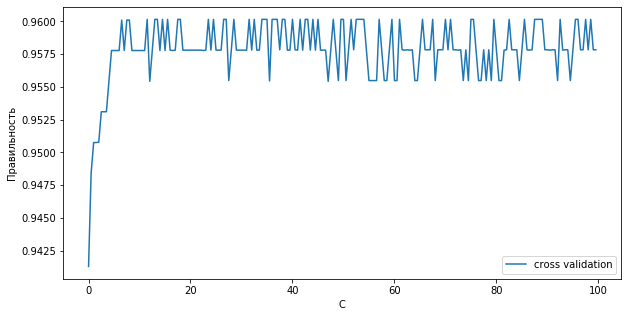

In [274]:
# Рассмотрим параметр C на интервале от 0 до 100
param = np.arange(0.01,100,0.5)
scores = []
for c in param:
    log_reg = LogisticRegression(C = c)
    scor = cross_val_score(log_reg, X_trainval, y_trainval, cv = 5)
    scores.append(np.mean(scor))

plt.plot(param, scores,label = 'cross validation')
plt.ylabel("Правильность")
plt.xlabel("C")
plt.legend()
plt.plot()
rcParams['figure.figsize'] = 20, 15

[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0, 1000000000.0, 10000000000.0, 100000000000.0, 1000000000000.0, 10000000000000.0, 100000000000000.0, 1000000000000000.0, 1e+16, 1e+17, 1e+18, 1e+19]


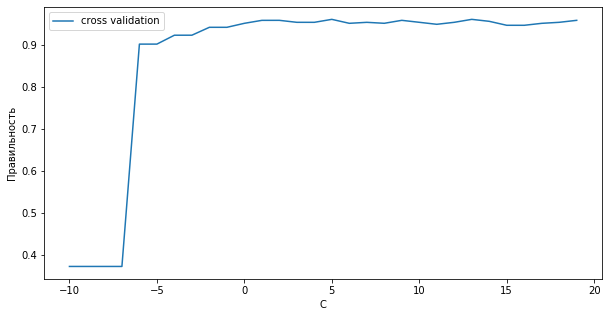

In [279]:
# Рассмотрим участок до 20 
n = np.arange(-10,20,1, dtype=float)
param = []
for i in n:
    param.append(10**i)
scores = []
for c in param:
    log_reg = LogisticRegression(C = c)
    scor = cross_val_score(log_reg, X_trainval, y_trainval, cv = 5)
    scores.append(np.mean(scor))

plt.plot(np.log10(param), scores,label = 'cross validation')
plt.ylabel("Правильность")
plt.xlabel("C")
plt.legend()
plt.plot()
rcParams['figure.figsize'] = 10, 5

print(param)

# видим, что график колеблется и достигает высоких значениях в местах около точек 5,7 и 13

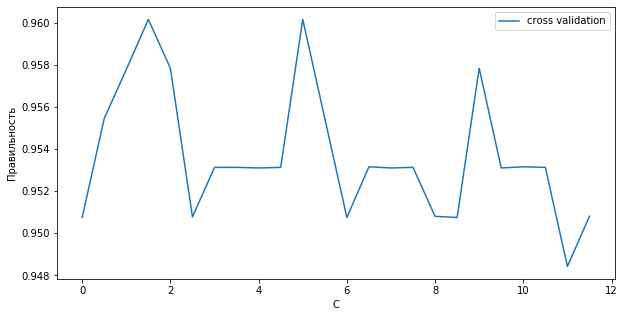

In [286]:
# расммотрим этот участок
n = np.arange(0,12,0.5, dtype=float)
param = []
for i in n:
    param.append(10**i)
scores = []
for c in param:
    log_reg = LogisticRegression(C = c)
    scor = cross_val_score(log_reg, X_trainval, y_trainval, cv = 5)
    scores.append(np.mean(scor))

plt.plot(np.log10(param), scores,label = 'cross validation')
plt.ylabel("Правильность")
plt.xlabel("C")
plt.legend()
plt.plot()
rcParams['figure.figsize'] = 10, 5

Промежуток [0.6-2.2]
Наибольшее значение правильности, равное 0.9601628558400105
при С = [1.1999999999999997, 1.4999999999999998, 1.5999999999999996, 1.6999999999999997]

Промежуток [4.1-5.9]
Наибольшее значение правильности, равное 0.9601628558400105
при С = [4.599999999999998, 4.799999999999997]

Промежуток [8.1-9.9]
Наибольшее значение правильности, равное 0.9578646342257834
при С = [9.599999999999994]



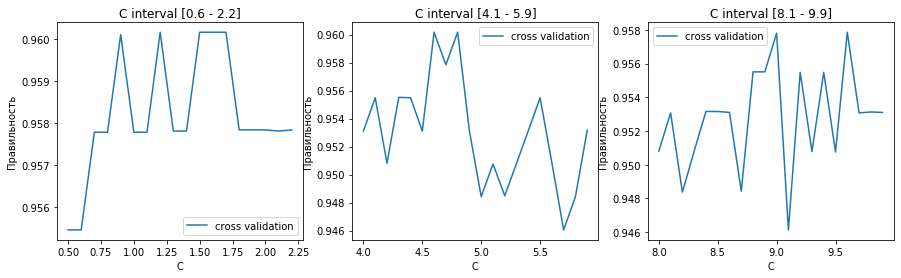

In [327]:
# Рассмотрим 3 участка

fig, axes = plt.subplots(1, 3, figsize=(15, 4)) # задаем сетку для графиков

sector_1 = np.arange(0.5,2.3,0.1, dtype=float) # задаем участки
sector_2 = np.arange(4,6,0.1, dtype=float)
sector_3 = np.arange(8, 10, 0.1, dtype=float)


for sector,ax in zip([sector_1,sector_2,sector_3], axes):
    param = []
    for point in sector:
        param.append(10**point)
        scores = []
        for c in param:
            log_reg = LogisticRegression(C = c)
            scor = cross_val_score(log_reg, X_trainval, y_trainval, cv = 5)
            scores.append(np.mean(scor))
    ax.set_title("C interval [{} - {}]".format(sector[1],round(sector[-1],1)))    
    ax.plot(np.log10(param), scores,label = 'cross validation')
    ax.set_ylabel("Правильность")
    ax.set_xlabel("C")
    ax.legend()
    ax.plot()
    
    max_score = 0                        # определяем максимальное значение правильности на заданном интервале
    for item in scores:
        if item > max_score:
            max_score = item
    
    max_C = []                           # при каком значении С достигается max значение
    for k in range(len(scores)):
        if scores[k] == max_score:
            max_C.append(np.log10(param)[k])
            
    print ('Промежуток [{}-{}]'.format(sector[1],round(sector[-1],1)))
    print('Наибольшее значение правильности, равное {}'.format(max_score))
    print('при С = {}\n'.format(max_C))
   
    #rcParams['figure.figsize'] = 20, 15            

In [7]:
# sector_1 max C = 1.2 
# sector_2 max C = 4.6 
# сравним

log_reg = LogisticRegression(C = 1.2)
scor = cross_val_score(log_reg, X_trainval, y_trainval, cv = 5)
print('Приавильность при С = 1.2: {}'.format(np.mean(scor)))

log_reg = LogisticRegression(C = 4.6)
scor = cross_val_score(log_reg, X_trainval, y_trainval, cv = 5)
print('Приавильность при С = 4.6: {}'.format(np.mean(scor)))

Приавильность при С = 1.2: 0.9507504397107681
Приавильность при С = 4.6: 0.9554289622825876


In [30]:
log_reg = LogisticRegression(C = 4.6)
log_reg.fit(X_trainval,y_trainval)
test_score_4_6 = log_reg.score(X_test,y_test)

In [9]:
test_score_4_6

0.9370629370629371

C = 1.20 правильность = 0.9371 AUC = 0.993
C = 4.60 правильность = 0.9371 AUC = 0.992


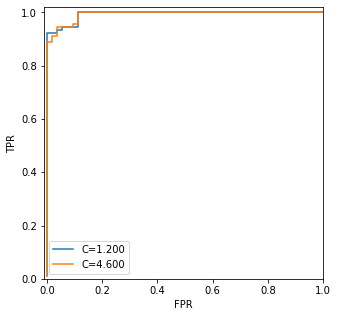

In [135]:
from sklearn.metrics import roc_auc_score, roc_curve

plt.figure()

C = [1.2,4.6]
for c in C:
    log_reg = LogisticRegression(C = c).fit(X_trainval, y_trainval)
    accuracy = log_reg.score(X_test, y_test)
    auc = roc_auc_score(y_test, log_reg.decision_function(X_test))
    fpr, tpr, _ = roc_curve(y_test , log_reg.decision_function(X_test))
    print("C = {:.2f} правильность = {:.4f} AUC = {:.3f}".format(c, accuracy, auc))
    plt.plot(fpr, tpr, label="C={:.3f}".format(c))
    
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc="best")
plt.show()

## ## Установка порогового значения по вероятности, Error

In [242]:
for c in C:
    for prob in [0.1,0.99]:
        log_reg = LogisticRegression(C = c) 
        log_reg.fit(X_trainval, y_trainval) # обучаем модель на данных, которые есть изначально
        y_pred_lower_threshold = (log_reg.predict_proba(X_trainval) > prob).astype(int) # устанавливаем порог
        log_reg.fit(X_trainval,y_pred_lower_threshold) # обучаем модель заново
        accuracy = log_reg.score(X_test, y_test)
        auc = roc_auc_score(y_test, log_reg.decision_function(X_test))
        fpr, tpr, _ = roc_curve(y_test , log_reg.decision_function(X_test))
        print("C = {:.2f} порог = {:.2f} правильность = {:.4f} AUC = {:.3f}".format(c,prob, accuracy, auc))
        plt.plot(fpr, tpr, label="C={:.3f}, p={:.2f}".format(c,prob))
    
       
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc="best")
plt.show()

ValueError: bad input shape (426, 2)

In [245]:
log_reg = LogisticRegression(C = 4.6)
log_reg.fit(X_trainval, y_trainval)

LogisticRegression(C=4.6, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [261]:
print((log_reg.predict_proba(X_trainval))[:2])

[[0.009366   0.990634  ]
 [0.99813713 0.00186287]]


In [253]:
print((log_reg.predict_proba(X_trainval)>0.5).astype(int)[:10])

[[0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]]


In [262]:
print((log_reg.predict_proba(X_trainval)>0.009).astype(int)[:10])

[[1 1]
 [1 0]
 [0 1]
 [1 1]
 [0 1]
 [1 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]]


## ## Ошибка, Мюллер стр 310


In [232]:


from sklearn.metrics import classification_report

lg = LogisticRegression(C = 0.1)
lg.fit(X_trainval,y_trainval)
print(classification_report(y_test, lg.predict(X_test)))

             precision    recall  f1-score   support

          0       0.91      0.91      0.91        53
          1       0.94      0.94      0.94        90

avg / total       0.93      0.93      0.93       143



In [244]:
y_pred_lower_threshold = (lg.predict_proba(X_test) > 0.3).astype(int)
print(classification_report(y_test, y_pred_lower_threshold))

ValueError: Mix type of y not allowed, got types {'binary', 'multilabel-indicator'}

Приавильность при С = 4.6: 0.9554289622825876


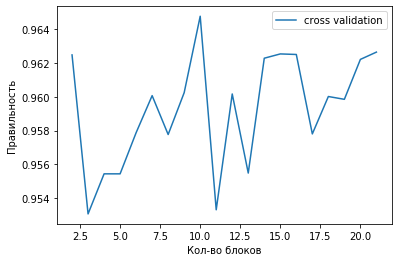

In [42]:
# при C = 4.6 достигается наибольшая точность 
log_reg = LogisticRegression(C = 4.6)
scor = cross_val_score(log_reg, X_trainval, y_trainval, cv = 5)
print('Приавильность при С = 4.6: {}'.format(np.mean(scor)))

# влияние кол-ва блоков в кросс валидации на ззначение правильности
blocks = np.arange(2,22,1)
scores = []
for b in blocks:
    log_reg = LogisticRegression(C = 4.6)
    scor = cross_val_score(log_reg, X_trainval, y_trainval, cv = b)
    scores.append(np.mean(scor))

plt.plot(blocks, scores,label = 'cross validation')
plt.ylabel("Правильность")
plt.xlabel("Кол-во блоков")
plt.legend()
plt.plot()
rcParams['figure.figsize'] = 5, 5

In [100]:
# При параметре C = 4.6 и cv = 10 достигается правильность больше 96%

log_reg = LogisticRegression(C = 4.6)
scor = cross_val_score(log_reg, X_trainval, y_trainval, cv = 10)
print(np.mean(scor))

0.9647786511087701


In [102]:
log_reg.fit(X_trainval,y_trainval)
print("Правильность на обучающем наборе: {:.2f}".format(log_reg.score(X_trainval, y_trainval)))
print("Правильность на тестовом наборе: {:.2f}".format(log_reg.score(X_test, y_test)))

Правильность на обучающем наборе: 0.97
Правильность на тестовом наборе: 0.94


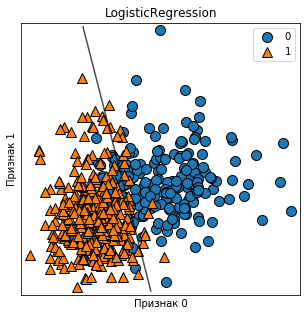

In [103]:
X = cancer.data[:,:2]
y = cancer.target
clf = log_reg.fit(X,y)

mglearn.plots.plot_2d_separator(clf, X, eps=0.5, alpha=.7)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.title("{}".format(clf.__class__.__name__))
plt.xlabel("Признак 0")
plt.ylabel("Признак 1")
plt.legend()
plt.show()

## Размер контрольного множества

In [399]:
#Разбивка данных на обчающий и тестовый наборы с разной величиной контрольной выборки

def procent_of_test_size(control_sizes, data, target):
    scores = []
    data_strucrure = {'%_test_size': ['original'],  # формируем имена колонок
                      'train_size':[cancer.data.shape[0]],
                      'test_size': [cancer.data.shape[0]] , 
                      'mean': [round(np.mean(data))] , 
                      'var': [round(np.var(data))] ,
                      'score': [0]}
    df = pd.DataFrame(data_strucrure)        # создаем датафрейм 
      
    for size in control_sizes:
        train_size = 1 - size
        test_percent = size*100
        X_trainval, X_test, y_trainval, y_test = train_test_split(data, target, 
                                                                  stratify = target, 
                                                                  random_state = 0,
                                                                  test_size = size,
                                                                  train_size = train_size)
        train_size = X_trainval.shape 
        test_size = X_test.shape
        mean = np.mean(X_trainval)
        var = np.var(X_trainval)
    
        log_reg = LogisticRegression(C = 4.6)
        scor = cross_val_score(log_reg, X_trainval, y_trainval, cv = 5)
        score = np.mean(scor)
        scores.append(score)
    
    
        new_row = {'%_test_size': test_percent, 
                   'train_size': train_size[0], 
                   'test_size': test_size[0], 
                   'mean': round(mean,2), 
                   'var': round(var,2),
                   'score': round(score,3)}
        
        
        df = df.append(new_row, ignore_index=True)

        
    plt.plot(control_sizes*100, scores)
    plt.ylabel("Правильность")
    plt.xlabel("Размер контрольного множества, %")
    plt.title('Правильность логистической регрессии при разных размерах контрольной выборки')
    plt.plot()
    rcParams['figure.figsize'] = 5, 5        
    
    return df


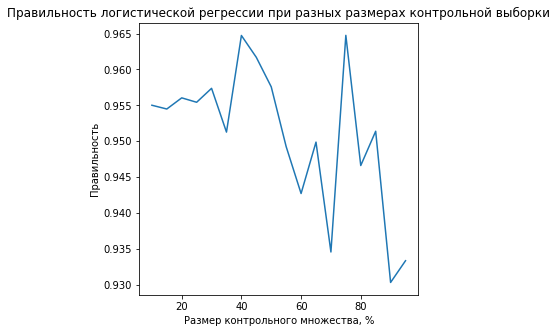

In [401]:
control_sizes = np.arange(0.1,1.0,0.05)
cancer_data_df = procent_of_test_size(control_sizes,cancer.data, cancer.target )

In [402]:
cancer_data_df

,%_test_size,train_size,test_size,mean,var,score
0,original,569.0,569.0,62.00,52120.00,0.000
1,10,512.0,57.0,62.12,52900.28,0.955
2,15,483.0,86.0,62.12,53115.51,0.954
3,20,455.0,114.0,62.10,53276.72,0.956
4,25,426.0,143.0,61.79,52577.18,0.955
5,30,398.0,171.0,61.73,52504.21,0.957
6,35,369.0,200.0,61.67,52699.77,0.951
7,40,341.0,228.0,61.88,53446.57,0.965
8,45,312.0,257.0,62.04,54202.32,0.962
9,50,284.0,285.0,62.03,54157.80,0.958


In [423]:
print('max mean value:',cancer_data_df["mean"].max())
print('min mean value:',cancer_data_df["mean"].min())

print()

print('max variance value:',cancer_data_df["var"].max())
print('min variance value:',cancer_data_df["var"].min())

max mean value: 63.13
min mean value: 54.76

max variance value: 59118.88
min variance value: 37708.48


[]

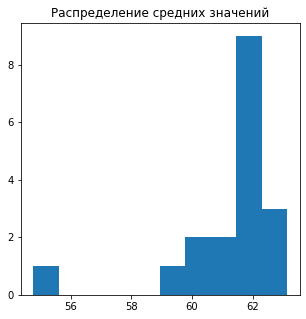

In [421]:
plt.hist(cancer_data_df["mean"][1:])
plt.title('Распределение средних значений')
plt.plot()

# Отбор значимых признаков (PCA) и классификация

### PCA

In [48]:
from sklearn.preprocessing import StandardScaler

In [122]:
# разбиваем выборку на тренировочный и тестовый наборы 
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                         stratify = cancer.target, random_state = 0)

# масштабируем данные, чтобы они имели var = 1
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [54]:
np.var(X_train_scaled)

1.0000000000000002

In [80]:
# применяем метод PCA (главныйх компонент), чтобы снизить размерность данных (с меньшей потерей информации)

from sklearn.decomposition import PCA
pca = PCA(n_components = 2).fit(X_train_scaled) # оставляем 2 главные компоненты, 
                                                #чтобы данные можно было отрисовать график

X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Форма исходного массива: {}".format(str(X_scaled.shape)))
print("Форма массива после сокращения размерности: {}".format(str(X_train_pca.shape)))


Форма исходного массива: (426, 30)
Форма массива после сокращения размерности: (426, 2)


Text(0, 0.5, 'Вторая главная компонента')

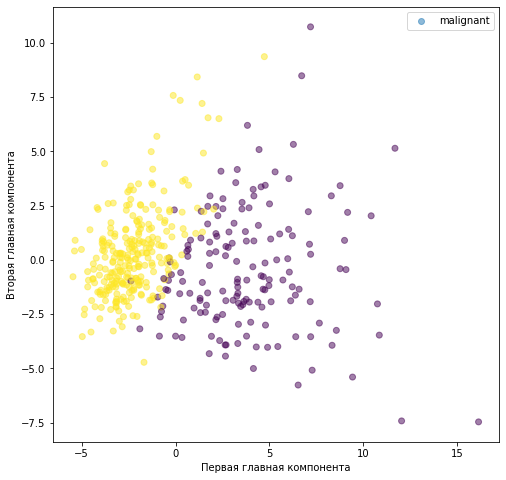

In [82]:
# строим график 
plt.figure(figsize=(8, 8))
plt.scatter(X_train_pca[:,0],X_train_pca[:,1], c = y_train, alpha= 0.5)

plt.legend(cancer.target_names)

plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")

In [83]:
# Теперь мы можем использовать новое представление, чтобы классифицировать данные
# используя классификатор LinearSVC

from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0)
clf.fit(X_train_pca,y_train)

print("Правильность на обучающем наборе: {:.2f}".format(clf.score(X_train_pca, y_train)))
print("Правильность на тестовом наборе: {:.2f}".format(clf.score(X_test_pca, y_test)))

Правильность на обучающем наборе: 0.96
Правильность на тестовом наборе: 0.93


In [92]:
# метод k ближайших соседей

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train_pca,y_train)
print("Правильность на обучающем наборе: {:.2f}".format(knn.score(X_train_pca, y_train)))
print("Правильность на тестовом наборе: {:.2f}".format(knn.score(X_test_pca, y_test)))

Правильность на обучающем наборе: 1.00
Правильность на тестовом наборе: 0.90


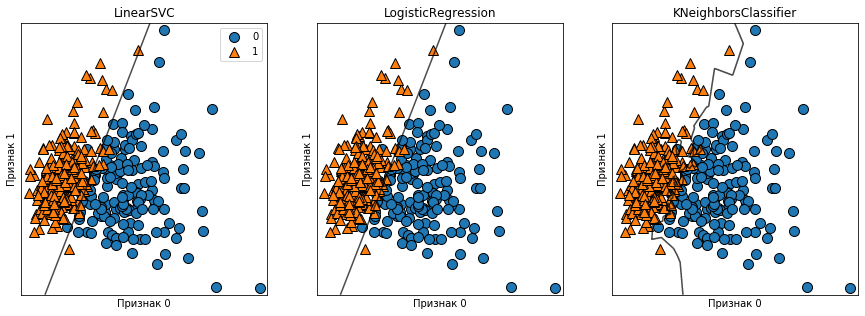

In [98]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for model, ax in zip([LinearSVC(), LogisticRegression(C = 4.6),KNeighborsClassifier(n_neighbors=1)], axes):
    clf = model.fit(X_train_pca, y_train)
    mglearn.plots.plot_2d_separator(clf, X_train_pca, fill=False, eps=0.5, ax=ax, alpha=.7)
    mglearn.discrete_scatter(X_train_pca[:, 0], X_train_pca[:, 1], y_train, ax=ax)
    ax.set_title("{}".format(clf.__class__.__name__))
    ax.set_xlabel("Признак 0")
    ax.set_ylabel("Признак 1")
axes[0].legend()
plt.show()

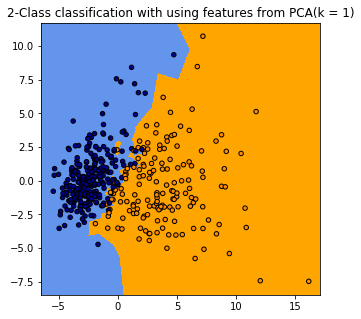

In [99]:
# Отрисуем метод одного ближайшего соседа более подробно

from sklearn import neighbors
n_neighbors = 1

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=cmap_bold,edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max()) 
plt.ylim(yy.min(), yy.max())
plt.title("2-Class classification with using features from PCA(k = %i)"
% (n_neighbors))

plt.show()

In [ ]:
# При методе  k ближайших соседей  модель хорошо предсказывает данные на тренировочных данных (100%), 
# но имеет более низкую обобщающую способность (90%). По графикам видно, что модель переобучена.

# На графиках также видно, что метод опорных векторов и логистическая регрессия не сильно отличаются и должны довать схожий результат.
# Так оно и есть. 
# При методе опорных векторов на тестовой выборке правильность = 96%, на тренировочной = 93%.
# При линейной регрессии на тестовой выборке правильность = 97%,  на тренировочной= 94%.
# Таким образом, использование логистической регрессии для классификации данного датасета яв-ся более целесообразным.

### leave-one-out

In [74]:
X_trainval, X_test, y_trainval, y_test = train_test_split(cancer.data, cancer.target, 
                                                         stratify = cancer.target, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval,y_trainval, random_state = 0)



from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
log_reg = LogisticRegression(C = 4.6)
scores = cross_val_score(log_reg, X_trainval,y_trainval, cv=loo)
print("Количество итераций: ", len(scores))
print("Средняя правильность: {:.2f}".format(scores.mean()))

Количество итераций:  426
Средняя правильность: 0.96
